In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import re
import os
import pandas as pd

from result_utils import *

### Common function

In [3]:
handover_type = 'CU-1'
sim_length = 30
results_dir = '../results/'
satellites_num = 76
link_bandwidth = 1000
dynamic_demands = True

AS = [[1, satellites_num + 49]]
gw_indices = [x for x in range(satellites_num + 1, satellites_num + 6)]
cell_indices = [x for x in range(satellites_num + 6, satellites_num + 50)]

topo_dir = '../results/'
change_file_list = ['baseline_small_topo_leo_change.txt', 'bad_results/baseline2_small_topo_leo_change.txt', 'holistic_small_topo_leo_change.txt']
results_dir_list = ['baseline_small', 'bad_results/baseline2_small', 'holistic_small']
delay_dir_list = ['baseline_small_delay/', 'bad_results/baseline2_small_delay/', 'holistic_small_delay/']

# Load cell GW assignments
assignments = np.genfromtxt('./sim_configs/small_scenario/cell_assignment.csv', delimiter=',', dtype=int)

# Load cell demands
sat_cell_assignments = []
for gw_idx in range(len(gw_indices)):
    assignment_csv = pd.read_csv(f'./sim_configs/small_scenario/sat_cell_assignments/gw0{gw_idx}_flows.csv')
    sat_cell_assignments.append(assignment_csv)

original_demands = np.zeros((sim_length, len(cell_indices)), dtype=float)
if dynamic_demands:
    # assignments configuration
    for time_idx in range(sim_length):
        for cell_idx, _ in enumerate(cell_indices):
            target_gw_idx = assignments[cell_idx]
            sat_cell_df = sat_cell_assignments[target_gw_idx]
            original_demands[time_idx, cell_idx] = float(sat_cell_df.loc[
                (sat_cell_df['t'] == time_idx) &
                (sat_cell_df['cell'] == cell_idx)
            ]['init_demand'])
else:
    begin_demand = np.genfromtxt('./sim_configs/small_scenario/demands.csv', delimiter=',', dtype=float)
    for time_idx in range(sim_length):
        original_demands[time_idx, :] = begin_demand

demand_ratio = link_bandwidth / np.max(original_demands)
demands = original_demands * demand_ratio

change_matrix_list = []
change_time_list = []

for topo_file in change_file_list:
    change_file = topo_dir + topo_file
    change_matrix, change_time = construct_change_matrix(len(cell_indices), change_file, cell_indices, sim_length-1)
    change_matrix_list.append(change_matrix)
    change_time_list.append(change_time)

/tmp/ipykernel_3152353/837959832.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  original_demands[time_idx, cell_idx] = float(sat_cell_df.loc[


Time: 2:
Add link: 37 85
Add link: 39 88
Add link: 44 92
Add link: 44 93
Add link: 49 99
Add link: 44 105
Add link: 39 109
Add link: 39 118
Add link: 37 119
Add link: 39 124
Del link: 27 85
Del link: 32 88
Del link: 37 92
Del link: 32 93
Del link: 44 99
Del link: 37 105
Del link: 32 109
Del link: 44 118
Del link: 27 119
Del link: 32 124
Time: 3:
Add link: 62 82
Add link: 69 83
Add link: 44 84
Add link: 54 85
Add link: 44 86
Add link: 54 87
Add link: 62 90
Add link: 69 91
Add link: 62 93
Add link: 49 94
Add link: 62 95
Add link: 62 96
Add link: 54 97
Add link: 54 100
Add link: 60 101
Add link: 60 102
Add link: 62 104
Add link: 54 106
Add link: 62 108
Add link: 69 111
Add link: 54 113
Add link: 54 114
Add link: 54 115
Add link: 54 116
Add link: 69 117
Add link: 49 118
Add link: 54 119
Add link: 44 120
Add link: 62 122
Add link: 54 125
Del link: 32 82
Del link: 39 83
Del link: 37 84
Del link: 37 85
Del link: 32 86
Del link: 37 87
Del link: 32 90
Del link: 39 91
Del link: 44 93
Del link: 3

## Throughput

### Across algorithms

In [4]:
total_transfer_list = []
total_demands_list = []
transfer_per_sat_list = []
demands_per_sat_list = []
transfer_matrix_list = []

for idx, folder in enumerate(results_dir_list):
    file_dir = results_dir + folder
    change_time = change_time_list[idx]
    change_matrix = change_matrix_list[idx]
    delay_dir = results_dir + delay_dir_list[idx]

    # get throughput results
    total_transfer, total_demands, transfer_per_sat, demands_per_sat, transfer_matrix = get_throughput_results(
        file_dir, cell_indices, gw_indices, assignments, sim_length, demands, change_time, 
        change_matrix, handover_type, delay_dir)

    total_transfer_list.append(total_transfer)
    total_demands_list.append(total_demands)
    transfer_per_sat_list.append(transfer_per_sat)
    demands_per_sat_list.append(demands_per_sat)
    transfer_matrix_list.append(transfer_matrix)

AssertionError: 

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (0,).

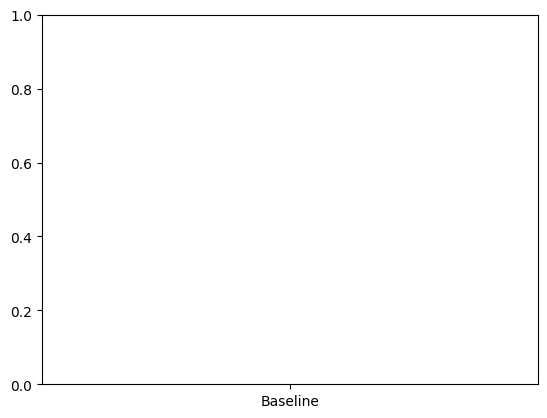

In [5]:
service_rates = []

for i in range(len(total_transfer_list)):
    total_trans = total_transfer_list[i]
    total_demand = total_demands_list[i]

    service_rates.append(total_trans/total_demand*100)

# Plot the service rates
algo = ['Baseline', 'Baseline2', 'holistic']

plt.bar(algo, service_rates)
plt.xlabel('Algorithm')
plt.ylabel('Total Service Rate (%)')
plt.savefig('../results/figures/total_throughput_algo.eps', format='eps')


In [15]:
print ("Total transfer: " + str(total_transfer) + " MBytes")
print ("Total demands: " + str(total_demands) + " MBytes")
print ("Total served rate: " + str(total_transfer/total_demands*100) + " %")

Total transfer: 77170.65 MBytes
Total demands: 136144.125 MBytes
Total served rate: 56.68305554866947 %


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


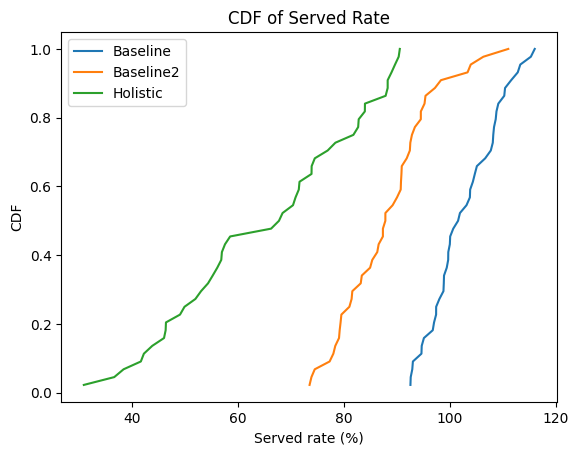

In [12]:
serve_rate_list = []
serve_rate_cdf_list = []


for i in range(len(transfer_per_sat_list)):
    transfer_per_sat = transfer_per_sat_list[i]
    demands_per_sat = demands_per_sat_list[i]

    serve_rate_per_sat = transfer_per_sat / demands_per_sat * 100
    sorted_serve_rate = np.sort(serve_rate_per_sat)
    serve_rate_list.append(sorted_serve_rate)
    # Calculate the CDF

    cdf = np.arange(1, len(sorted_serve_rate) + 1) / len(sorted_serve_rate)
    serve_rate_cdf_list.append(cdf)

# Plot the CDF
plt.plot(serve_rate_list[0], serve_rate_cdf_list[0], label='Baseline')
plt.plot(serve_rate_list[1], serve_rate_cdf_list[1], label='Baseline2')
plt.plot(serve_rate_list[2], serve_rate_cdf_list[2], label='Holistic')
plt.xlabel('Served rate (%)')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Served Rate')
plt.savefig('../results/figures/serve_rate_cdf.eps', format='eps')

### Across handover type

In [35]:
handover_types = ['CU-1', 'CU-2', 'DU-1', 'DU-2']

total_transfer_list_hand = []
total_demands_list_hand = []
transfer_per_sat_list_hand = []
demands_per_sat_list_hand = []

folder = 'starry_1000'

for idx, handover in enumerate(handover_types):
    file_dir = results_dir + folder
    change_time = change_time_list[0]
    change_matrix = change_matrix_list[0]
    delay_dir = results_dir + delay_dir_list[0]

    # get throughput results
    total_transfer, total_demands, transfer_per_sat, demands_per_sat = get_throughput_results(
        file_dir, cell_indices, gw_indices, assignments, sim_length, demands, change_time, 
        change_matrix, handover, delay_dir)

    total_transfer_list_hand.append(total_transfer)
    total_demands_list_hand.append(total_demands)
    transfer_per_sat_list_hand.append(transfer_per_sat)
    demands_per_sat_list_hand.append(demands_per_sat)

FileNotFoundError: [Errno 2] No such file or directory: '../results/starry_1000/iperf/iperf_82_results.txt'

## number of hops

In [16]:
results_dir_list = ['bad_results/baseline_small', 'bad_results/baseline2_small', 'holistic_small']

hops_algo = []
success_links_algo = []

for folder in results_dir_list:
    traceroute_dir = results_dir + folder + '/traceroute/'
    file_list = os.listdir(traceroute_dir)
    traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

    total_hops = 0

    avg_hops_per_cell = [0 for x in cell_indices]
    success_links = [0 for x in cell_indices]

    for file in traceroute_files:
        cell = int(file.split('_')[2])
        with open(traceroute_dir + file, 'r') as f:
            traceroute_output = f.read()
        traceroute_lines = traceroute_output.split('\n')[:-1]
        hops = 0
        failed = 0
        if len(traceroute_lines) < 3:
            failed = 1
            continue

        for line in traceroute_lines[1:]:
            if '*' not in line or ('*' in line and '*' not in traceroute_lines[-1]):
                hops += 1
            elif '*' in line and '*' in traceroute_lines[-1]:
                failed = 1
                break
            
        if failed == 0:
            avg_hops_per_cell[cell_indices.index(cell)] += hops
            success_links[cell_indices.index(cell)] += 1

        # if 2 <= len(traceroute_lines) < 3:
        #     print (file)

        if len(traceroute_lines) > 6:
            print (file)

    hops_algo.append(avg_hops_per_cell)
    success_links_algo.append(success_links)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


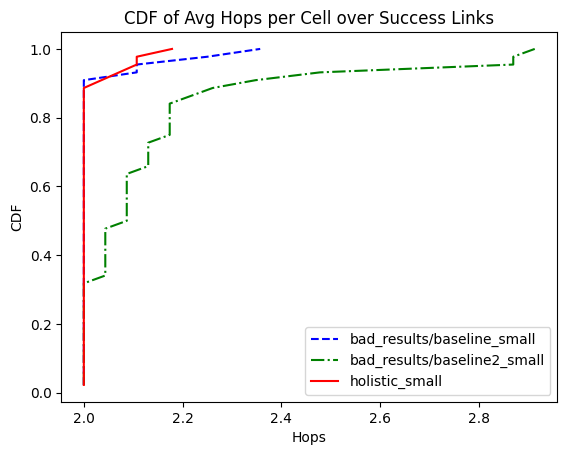

In [17]:
sorted_avg_hops_algo = []
cdf_algo = []

# Calculate the CDF
for idx in range(len(hops_algo)):
    sorted_avg_hops = np.sort(hops_algo[idx]/np.array(success_links_algo[idx]))
    cdf = np.arange(1, len(sorted_avg_hops) + 1) / len(sorted_avg_hops)
    sorted_avg_hops_algo.append(sorted_avg_hops)
    cdf_algo.append(cdf)

# Plot the CDF
styles = ['--b', '-.g', '-r']
for idx, result_dir in enumerate(results_dir_list):
    plt.plot(sorted_avg_hops_algo[idx], cdf_algo[idx], styles[idx], label=result_dir)
plt.xlabel('Hops')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Avg Hops per Cell over Success Links')
plt.savefig('../results/figures/avg_hops_cdf.eps', format='eps')

## links load

In [22]:
import re

traceroute_dir = results_dir + 'holistic_small' + '/traceroute/'
file_list = os.listdir(traceroute_dir)
traceroute_files = [file for file in file_list if file.startswith('traceroute_')]

trace_time = []

for file_name in traceroute_files:
    t = int(file_name.split('_')[1])
    if t not in trace_time:
        trace_time.append(t)
        
trace_time = sorted(trace_time)

total_hops = 0

sat_loads = [[0 for _ in range(76)] for _ in trace_time]
sat_links = [[0 for _ in range(76)] for _ in trace_time]

for file in traceroute_files:
    t = int(file.split('_')[1])
    cell_id = int(file.split('_')[2])
    with open(traceroute_dir + file, 'r') as f:
        traceroute_output = f.read()
        
    traceroute_lines = traceroute_output.split('\n')[:-1]
    if len(traceroute_lines) < 2:
        continue
    
    ip_addresses = []
    for line in traceroute_lines[1:]:
        if '*' not in line:
            ip_address = re.findall(r'\(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\)', line)
        else:
            continue
        ip_addresses.append(ip_address[0].replace('(', '').replace(')', '').split('.'))
    
    for ip in ip_addresses:
        
        if ip[-1] != '10' and int(ip[-2]) < 76:
            sat_links[trace_time.index(t)][int(ip[-2])] += 1
            sat_loads[trace_time.index(t)][int(ip[-2])] += demands[trace_time.index(t), cell_indices.index(cell_id)]
            # sat_loads[trace_time.index(t)][int(ip[-2])] += transfer_matrix_list[2][cell_indices.index(cell_id), trace_time.index(t)] * 8
            
            
    sat_loads = np.array(sat_loads)
    sat_links = np.array(sat_links)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


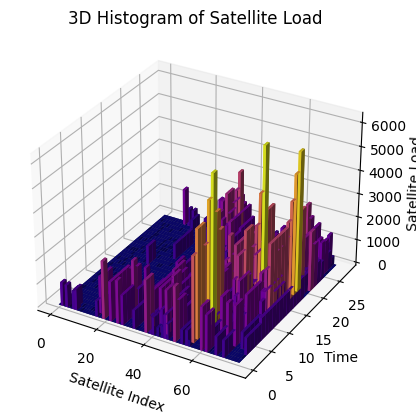

In [23]:
from matplotlib import cm

import matplotlib.pyplot as plt

# Plot the 3D histogram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = range(sat_loads.shape[1])
y = range(sat_loads.shape[0])
X, Y = np.meshgrid(x, y)
Z = sat_loads.flatten()

# Define colors based on Z values
colors = cm.plasma(Z / np.max(Z))

ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(Z), 1, 1, Z, color=colors)

# Set labels and title
ax.set_xlabel('Satellite Index')
ax.set_ylabel('Time')
ax.set_zlabel('Satellite Load')
ax.set_title('3D Histogram of Satellite Load')

# Show the plot
plt.savefig('../results/figures/sat_load_holistic.eps', format='eps')

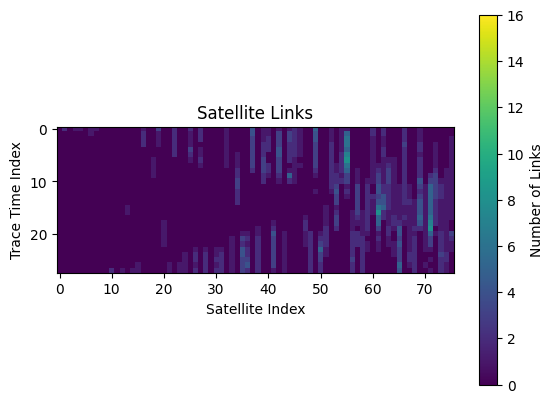

In [24]:
import matplotlib.pyplot as plt

# Plot the sat_links

plt.imshow(sat_links, cmap='viridis', vmax=16, vmin=0, interpolation='nearest')
plt.xlabel('Satellite Index')
plt.ylabel('Trace Time Index')
plt.title('Satellite Links')
plt.colorbar(label='Number of Links')
plt.savefig('../results/figures/sat_links_holistic.eps', format='eps')

## Network delay

## Unconneted cell rate

In [41]:
traceroute_dir = results_dir + 'holistic_small' + '/traceroute/'
file_list = os.listdir(traceroute_dir)

trace_times = []

for file_name in traceroute_files:
    t = int(file_name.split('_')[1])
    if t not in trace_times:
        trace_times.append(t)
        
trace_time = sorted(trace_time)

connected = np.zeros((len(cell_indices), len(trace_times)))

for t in trace_times:
    route_files = [file for file in file_list if file.startswith('traceroute_' + str(t) + '_')]

    for file in route_files:
        cell = int(file.split('_')[2])
        gw = int(file.split('_')[3].split('.')[0])
        with open(traceroute_dir + file, 'r') as f:
            traceroute_output = f.read()
        traceroute_lines = traceroute_output.split('\n')[:-1]

        if len(traceroute_lines) < 2:
            continue

        dst_ip = '9.' + str(gw) + '.' + str(gw) + '.10'

        if dst_ip in traceroute_lines[-1]:
            connected[cell_indices.index(cell), trace_times.index(t)] = 1
        else:
            print (file)


unconnected = 1 - connected

/tmp/ipykernel_2456136/1182333030.py:18: RuntimeWarning: invalid value encountered in divide
  colors = cm.viridis(Z / np.max(Z))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


unconnected rate: 0.0 %


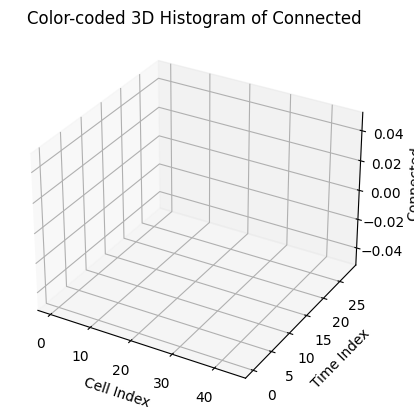

In [42]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the dimensions of the connected array
num_cells = len(cell_indices)
num_times = len(trace_times)

# Create X, Y, and Z arrays for the histogram
X, Y = np.meshgrid(range(num_cells), range(num_times))
Z = unconnected.flatten()

# Define colors based on Z values
colors = cm.viridis(Z / np.max(Z))

# Plot the 3D histogram
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(Z), 1, 1, Z, color=colors)

# Set labels and title
ax.set_xlabel('Cell Index')
ax.set_ylabel('Time Index')
ax.set_zlabel('Connected')
ax.set_title('Color-coded 3D Histogram of Connected')

# Show the plot
plt.savefig('../results/figures/unconnected_holistic.eps', format='eps')

print ("unconnected rate: {} %".format(np.sum(unconnected)/np.sum(np.ones(unconnected.shape))*100))

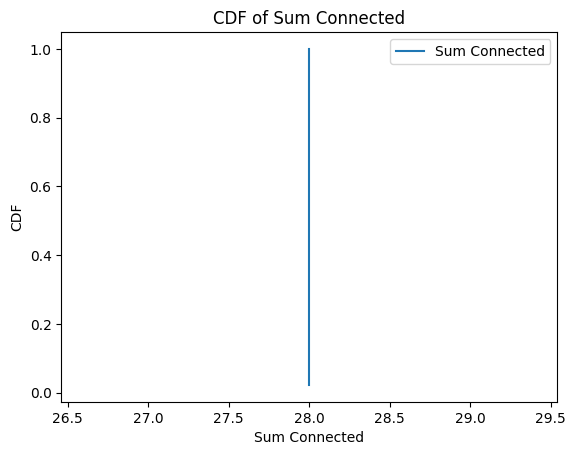

In [43]:
sum_connected = np.sum(connected, axis=1)

cdf = np.arange(1, len(sum_connected) + 1) / len(sum_connected)

# Plot the CDF of sum_connected
plt.plot(np.sort(sum_connected), cdf, label='Sum Connected')
plt.xlabel('Sum Connected')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Sum Connected')
plt.show()

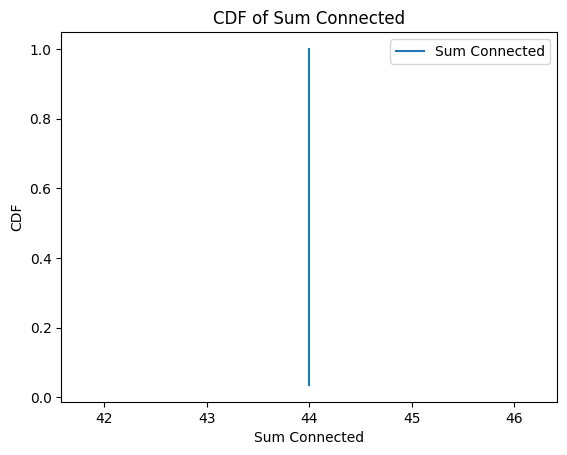

In [44]:
sum_connected = np.sum(connected, axis=0)

cdf = np.arange(1, len(sum_connected) + 1) / len(sum_connected)

# Plot the CDF of sum_connected
plt.plot(np.sort(sum_connected), cdf, label='Sum Connected')
plt.xlabel('Sum Connected')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF of Sum Connected')
plt.show()


### Number of handovers

In [45]:
results_dir_list = ['baseline_small', 'baseline2_small', 'holistic_small']

num_handovers = np.zeros((len(results_dir_list), len(cell_indices)), dtype=int)

for idx, matrix in enumerate(change_matrix_list):
    m = np.array(matrix)

    for t in range(m.shape[1]):
        for cell_idx in range(len(cell_indices)):
            if m[cell_idx, t, 0] != m[cell_idx, t, 1]:
                num_handovers[idx, cell_idx] += 1
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


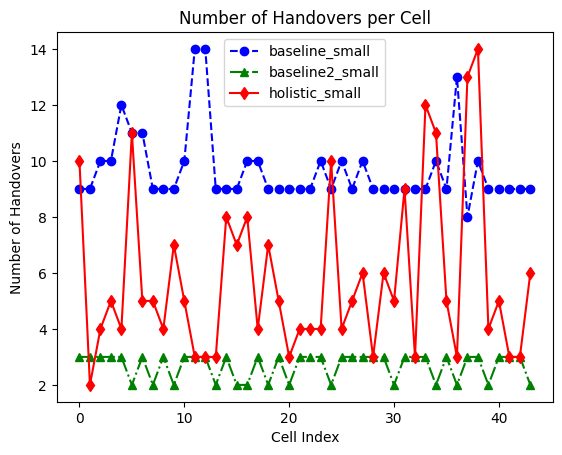

In [46]:
# Plotting with dots
styles = ['--bo', '-.g^', '-rd']
for idx, result_dir in enumerate(results_dir_list):
    plt.plot(range(len(cell_indices)), num_handovers[idx], styles[idx], label=result_dir)

plt.xlabel('Cell Index')
plt.ylabel('Number of Handovers')
plt.title('Number of Handovers per Cell')
plt.legend()
plt.savefig('../results/figures/num_handovers.eps', format='eps')

# Test playground

In [28]:
gw_indices = [x for x in range(satellites_num + 1, satellites_num + 6)]
cell_indices = [x for x in range(satellites_num + 6, satellites_num + 50)]
delay_file = results_dir + 'holistic_small_delay/7.txt'

matrix = np.genfromtxt(delay_file, delimiter=',', dtype=float)

In [29]:
nonzero_indices = np.nonzero(matrix[119])
print(nonzero_indices)

(array([54]),)


In [25]:
matrix.shape

(125, 125)